<a href="https://colab.research.google.com/github/FlyingWorkshop/DiffusionGNNTutorial/blob/main/molecule_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
!pip install torch_geometric
!pip install rdkit

  Using cached torch_geometric-2.4.0-py3-none-any.whl (1.0 MB)
  Using cached rdkit-2023.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.5 MB)


In [4]:
# load QM9 dataset
# documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html?highlight=qm9#torch_geometric.datasets.QM9

from torch_geometric.datasets import QM9

dataset = QM9(root='drive/MyDrive/Tutorial/data/QM9/')

In [5]:
example = dataset[-1]
nf = example.x.shape[1]
example

Data(x=[16, 11], edge_index=[2, 40], edge_attr=[40, 4], y=[1, 19], pos=[16, 3], z=[16], smiles='[H]C1([H])[N@H+]2[C@@]3([H])[C@@]14O[C@@]1([H])[C@@]([H])([C@]24[H])[C@]13[H]', name='gdb_133885', idx=[1])

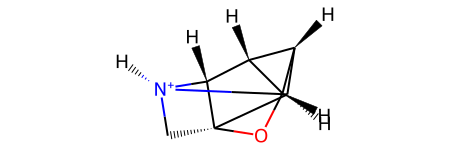

In [6]:
from rdkit import Chem

mol = Chem.MolFromSmiles(example.smiles)
mol

# Forward Diffusion

In [7]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Implement a simple equivariant graph convolutional layer (EGCL) and equivariant GNN (EGNN) from Hoogeboom paper
# Theory Ref: Appendix B and Eq (12)
# Code Ref: https://github.com/ehoogeboom/e3_diffusion_for_molecules/blob/main/egnn/egnn.py

class SimpleEGCL(nn.Module):
  def __init__(self, nf: int = 11, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self._nf = nf

    self._edge_mlp = None
    self._coordinate_mlp = nn.Sequential(
        # nn.Linear(nf * 2 + 2, nf),
        nn.Linear(1, nf),  # NOTE: for now, we ignore h
        nn.SiLU(),
        nn.Linear(nf, nf),
        nn.SiLU(),
        nn.Linear(nf, 1)
    )
    self._init_layers(self._coordinate_mlp)

  @staticmethod
  def _init_layers(mlp):
    for layer in mlp:
      if isinstance(layer, nn.SiLU):
          continue
      nn.init.xavier_uniform_(layer.weight)

  def _edge_operation(self):
    pass

  def _edge_inference_operation(self):
    pass

  def _node_update(self,):
    pass

  def _coordinate_update(self, norm, h):
    inp = norm.square().ravel().unsqueeze(-1)
    out = self._coordinate_mlp(inp).reshape((len(h), len(h), 1))
    return out

  def forward(self, x, h):
    diff = x - x.unsqueeze(1)
    norm = torch.norm(diff, dim=-1)
    normalized = diff / (norm + 1).unsqueeze(-1)
    x_next = x + torch.sum(normalized * self._coordinate_update(norm, h), dim=1)
    h_next = h
    return x_next, h_next

class SimpleEGNN(nn.Module):
  def __init__(self, nf: int = 11, num_layers: int = 1, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self._nf = nf
    self._num_layers = num_layers
    self._layers = nn.ModuleList([SimpleEGCL(nf) for _ in range(num_layers)])

  def forward(self, x, h):
    for layer in self._layers:
      x, h = layer(x, h)
    return x, h


class SimpleEDM:
  def __init__(
      self,
      model: SimpleEGNN,
      device,
      lr: float = 1e-3,
      nf: int = 11,
      max_timesteps: int = 10,
  ):
    self._device = device
    self._model = model.to(device)
    self._optimizer = optim.Adam(model.parameters(), lr=lr)
    self._loss_fn = nn.MSELoss()

    self._nf = nf
    self._max_timesteps = max_timesteps

    self._uniform_dist = torch.distributions.Uniform(low=0, high=max_timesteps)
    self._std_normal_dist = torch.distributions.MultivariateNormal(torch.zeros(nf + 3), torch.eye(nf + 3))

  def _alpha(self, t):
    """Controls how much signal is retained"""
    # return np.sqrt(1 - self._sigma(t))
    return 1 / t

  @staticmethod
  def _sigma(t):
    """Controls how much noise is added"""
    # TODO: change this
    return 0.005

  def _sample_noise(self, sample_shape):
    noise = self._std_normal_dist.sample(sample_shape=sample_shape)
    x_noise, h_noise = noise[:, :3], noise[:, 3:]
    x_noise -= torch.mean(x_noise)  # subtract center of gravity
    return torch.hstack((x_noise, h_noise))

  def _predict_noise(self, z, t):
    z_x, z_h = z[:, :3], z[:, 3:]
    x, h = self._model(z_x, z_h)
    pred_noise = torch.hstack((x - z_x, h))
    return pred_noise

  def optimize(self, example, verbose=False):
    """Algorithm 1"""
    example.to(self._device)
    x = example.pos
    h = example.x
    t = self._uniform_dist.sample().to(self._device)
    noise = self._sample_noise(sample_shape=(len(x),)).to(self._device)
    z = self._alpha(t) * torch.hstack((x, h)) + self._sigma(t) * noise
    self._optimizer.zero_grad()
    pred_noise = self._predict_noise(z, t)
    # loss = self._loss_fn(noise, pred_noise)
    loss = self._loss_fn(noise[:, :3], pred_noise[:, :3])
    loss.backward()
    self._optimizer.step()
    loss = loss.cpu().detach().numpy()
    return loss

0/0: 0.5403141379356384
0/250: 1.0009092092514038
0/500: 1.0613168478012085
0/750: 1.0677098035812378
1/0: 1.333023190498352
1/250: 1.0126206874847412
1/500: 1.0492279529571533
1/750: 1.0718133449554443
2/0: 1.1441445350646973
2/250: 0.9776521921157837
2/500: 1.028315782546997
2/750: 0.9794568419456482
3/0: 1.1136879920959473
3/250: 0.9664974808692932
3/500: 0.9661537408828735
3/750: 0.9694924354553223
4/0: 0.5645487904548645
4/250: 0.9868398904800415
4/500: 1.0177059173583984
4/750: 0.9581767320632935
5/0: 0.873064398765564
5/250: 1.01885986328125
5/500: 0.9756958484649658
5/750: 0.9607386589050293
6/0: 0.4636816382408142
6/250: 1.2085063457489014
6/500: 1.3716572523117065
6/750: 1.243430733680725
7/0: 1.3435277938842773
7/250: 1.1372860670089722
7/500: 1.0641025304794312
7/750: 1.1393508911132812
8/0: 1.0448691844940186
8/250: 1.0255076885223389
8/500: 1.0457911491394043
8/750: 1.0198485851287842
9/0: 0.1986522227525711
9/250: 0.9944051504135132
9/500: 1.1056623458862305
9/750: 1.128

Text(0.5, 0, 'Updates')

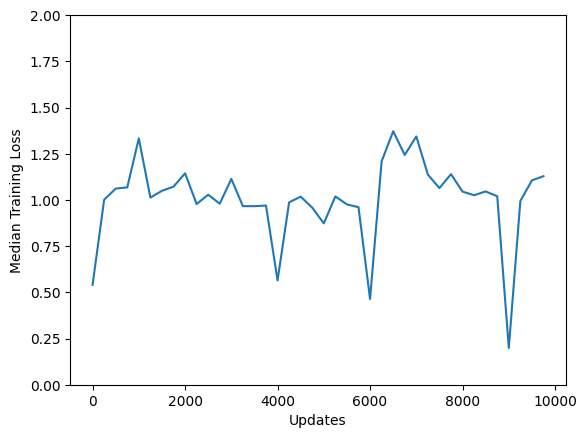

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
egnn = SimpleEGNN()
edm = SimpleEDM(model=egnn, max_timesteps=10, device=device)

epochs = 10
log_interval = 250
loss_history = []

for i in range(epochs):
  interval_history = []
  for j, example in enumerate(dataset[:1000]):
    loss = edm.optimize(example)
    interval_history.append(loss)
    if j % log_interval == 0:
      interval_loss = np.median(interval_history)
      print(f"{i}/{j}: {interval_loss}")
      loss_history.append(interval_loss)
      interval_history = []


plt.plot(range(0, len(loss_history) * log_interval, log_interval), loss_history)
plt.ylim(0, 2)
plt.ylabel("Median Training Loss")
plt.xlabel("Updates")

0: 1.190212368965149
10: 0.9374992847442627
20: 1.0299534797668457
30: 0.9355828762054443
40: 1.4037814140319824
50: 0.9328614473342896
60: 1.1072556972503662
70: 0.9790488481521606
80: 0.7802267074584961
90: 0.9686343669891357
100: 0.9672493934631348
110: 0.8322702646255493
120: 1.031808853149414
130: 0.8646115064620972
140: 0.8891474604606628
150: 1.1032352447509766
160: 1.4741652011871338
170: 1.3491289615631104
180: 1.0183743238449097
190: 1.0410867929458618
200: 0.9800909757614136
210: 0.9623864889144897
220: 1.0060837268829346
230: 1.0547996759414673
240: 1.1184804439544678
250: 1.0017173290252686
260: 1.020062804222107
270: 0.9251978397369385
280: 0.8792195916175842
290: 0.906807541847229
300: 1.0736356973648071
310: 0.9867812991142273
320: 0.9938045144081116
330: 0.9835988879203796
340: 1.0556597709655762
350: 1.2014825344085693
360: 1.1121017932891846
370: 1.178973913192749
380: 0.9937381744384766
390: 0.9159501791000366
400: 0.918839693069458
410: 0.9265952110290527
420: 0.95

Text(0.5, 0, 'Updates')

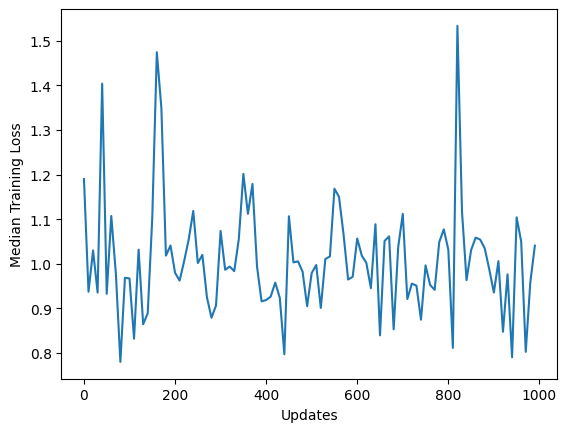

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
egnn = SimpleEGNN()
edm = SimpleEDM(model=egnn, max_timesteps=10, device=device)

epochs = 1000
log_interval = 10
loss_history = []
interval_history = []

for i in range(epochs):
  loss = edm.optimize(example)
  interval_history.append(loss)
  if i % log_interval == 0:
    interval_loss = np.median(interval_history)
    print(f"{i}: {interval_loss}")
    loss_history.append(interval_loss)
    interval_history = []


plt.plot(range(0, len(loss_history) * log_interval, log_interval), loss_history)
plt.ylabel("Median Training Loss")
plt.xlabel("Updates")